In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn import metrics
from sklearn.metrics import roc_auc_score, brier_score_loss

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
data = pd.read_csv('ml_case_training_data.csv')
output = pd.read_csv('ml_case_training_output.csv')
data_test = pd.read_csv('ml_case_test_data.csv')
data_hist = pd.read_csv('ml_case_training_hist_data.csv')
data = pd.merge(data, output, on = 'id')

data_test_id = data_test['id']
data_id = data['id']

In [3]:
print(data_test.isnull().sum())

id                             0
activity_new                2354
campaign_disc_ele           4024
channel_sales               1056
cons_12m                       0
cons_gas_12m                   0
cons_last_month                0
date_activ                     0
date_end                       0
date_first_activ            3147
date_modif_prod               45
date_renewal                   4
forecast_base_bill_ele      3147
forecast_base_bill_year     3147
forecast_bill_12m           3147
forecast_cons               3147
forecast_cons_12m              0
forecast_cons_year             0
forecast_discount_energy      24
forecast_meter_rent_12m        0
forecast_price_energy_p1      24
forecast_price_energy_p2      24
forecast_price_pow_p1         24
has_gas                        0
imp_cons                       0
margin_gross_pow_ele           2
margin_net_pow_ele             2
nb_prod_act                    0
net_margin                     3
num_years_antig                0
origin_up 

In [4]:
data.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,...,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,...,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0


1. ***id*** - contact id

2. ***activity_new*** -  category of the company's activity

3. ***campaign_disc_ele*** - code of the electricity campaign the customer last subscribed to

4. ***channel_sales*** - code of the sales channel

5. ***cons_12m*** - electricity consumption of the past 12 months 
    
6. ***cons_gas_12m*** - gas consumption of the past 12 months

7. ***cons_last_month*** - electricity consumption of the last month

8. ***date_activ*** - date of activation of the contract

9. ***date_end*** - registered date of the end of the contract

10. ***date_first_activ*** - date of first contract of the client

11. ***date_modif_prod*** - date of last modification of the product

12. ***date_renewal*** - date of the next contract renewal

13. ***forecast_base_bill_ele*** - forecasted electricity bill baseline for next month

14. ***forecast_base_bill_year*** - forecasted electricity bill baseline for calendar year

15. ***forecast_bill_12m*** - forecasted electricity bill baseline for 12 months

16. ***forecast_cons*** - forecasted electricity consumption for next month

17. ***forecast_cons_12m*** - forecasted electricity consumption for next 12 months

18. ***forecast_cons_year*** - forecasted electricity consumption for next calendar year

19. ***forecast_discount_energy*** - forecasted value of current discount

20. ***forecast_meter_rent_12m*** - forecasted bill of meter rental for the next 12 months

21. ***forecast_price_energy_p1*** - forecasted energy price for 1st period

22. ***forecast_price_energy_p2*** - forecasted energy price for 2nd period

23. ***forecast_price_pow_p1*** - forecasted power price for 1st period

24. ***has_gas*** - indicated if client is also a gas client

25. ***imp_cons*** - current paid consumption

26. ***margin_gross_pow_ele*** - gross margin on power subscription

27. ***margin_net_pow_ele*** - net margin on power subscription

28. ***nb_prod_act*** - number of active products and services

29. ***net_margin*** - total net margin

30. ***num_years_antig*** - antiquity of the client (in number of years)

31. ***origin_up*** - code of the electricity campaign the customer first subscribed to

32. ***pow_max*** - subscribed power

33. ***churn*** - churn status

In [5]:
data.dtypes

id                           object
activity_new                 object
campaign_disc_ele           float64
channel_sales                object
cons_12m                      int64
cons_gas_12m                  int64
cons_last_month               int64
date_activ                   object
date_end                     object
date_first_activ             object
date_modif_prod              object
date_renewal                 object
forecast_base_bill_ele      float64
forecast_base_bill_year     float64
forecast_bill_12m           float64
forecast_cons               float64
forecast_cons_12m           float64
forecast_cons_year            int64
forecast_discount_energy    float64
forecast_meter_rent_12m     float64
forecast_price_energy_p1    float64
forecast_price_energy_p2    float64
forecast_price_pow_p1       float64
has_gas                      object
imp_cons                    float64
margin_gross_pow_ele        float64
margin_net_pow_ele          float64
nb_prod_act                 

In [6]:
data["date_activ"] = pd.to_datetime(data["date_activ"])
data["date_end"] = pd.to_datetime(data["date_end"])
data["date_first_activ"] = pd.to_datetime(data["date_first_activ"])
data["date_modif_prod"] = pd.to_datetime(data["date_modif_prod"])
data["date_renewal"] = pd.to_datetime(data["date_renewal"])
data['has_gas'] = data['has_gas'].str.contains('t').astype(bool)

# Do the same with the testing data
data_test["date_activ"] = pd.to_datetime(data_test["date_activ"])
data_test["date_end"] = pd.to_datetime(data_test["date_end"])
data_test["date_first_activ"] = pd.to_datetime(data_test["date_first_activ"])
data_test["date_modif_prod"] = pd.to_datetime(data_test["date_modif_prod"])
data_test["date_renewal"] = pd.to_datetime(data_test["date_renewal"])
data_test['has_gas'] = data_test['has_gas'].str.contains('t').astype(bool)

# Descriptive Statistics

In [7]:
# Counting the number of customers by counting unique ids.
customers = data['id'].value_counts()
print("We have uniques customers: " + str(len(customers)))

# Check the max numbers of times we can see the same customer in a dataset.
print("Each customer appears in a dataset " + str(max(customers)) + " time.")

We have uniques customers: 16096
Each customer appears in a dataset 1 time.


In [8]:
data["total_cons_12m"] = data["cons_12m"] + data["cons_gas_12m"]
data_test["total_cons_12m"] = data_test["cons_12m"] + data_test["cons_gas_12m"]

total_cons_12m = data["total_cons_12m"]
elc_cons_12m = data["cons_12m"]
gas_cons_12m = data["cons_gas_12m"]
sub_power = data["pow_max"]
forecast_cons_12m = data['forecast_cons_12m']
date_activated = pd.to_datetime(data['date_activ'])

/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


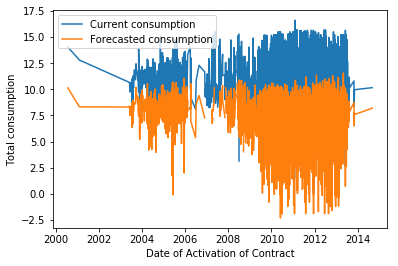

In [9]:
log_curr_cons = np.log(elc_cons_12m)
log_fore_cons = np.log(forecast_cons_12m)

consumption = pd.DataFrame({'date_activated':date_activated,
     'total_curr_cons':log_curr_cons,
     'total_fore_cons':log_fore_cons})
consumption.sort_values('date_activated',inplace = True)

plt.plot(consumption['date_activated'], consumption['total_curr_cons'])
plt.plot(consumption['date_activated'], consumption['total_fore_cons'])
plt.legend(['Current consumption', 'Forecasted consumption'], loc = 'upper left')
plt.xlabel('Date of Activation of Contract')
plt.ylabel('Total consumption')
plt.savefig('forecast.png')
plt.show()

Correlation between the electricity consumption and subscribed power separately for gas users and non-gas users. We see the generat trend in channel sales.

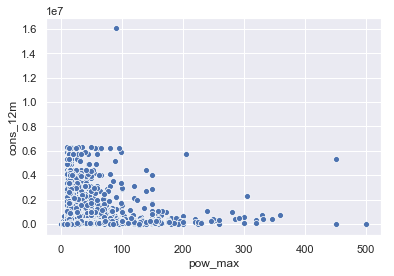

The pearson correlation is 0.1024225583501766
The kendall correlation is 0.2824519560330777


In [10]:
# Correlation between subscribed power and total consumption using two different correlation methods
sns.set()
ax = sns.scatterplot(x = "pow_max", y = "cons_12m", data = data)
plt.savefig('consumption.png')
plt.show()

print("The pearson correlation is", str(data["cons_12m"].corr(data["pow_max"], method = 'pearson')))
print("The kendall correlation is", str(data["cons_12m"].corr(data["pow_max"], method = 'kendall')))
# This implies that there is a weak positive correlation between the electricity consumption and subscribed power

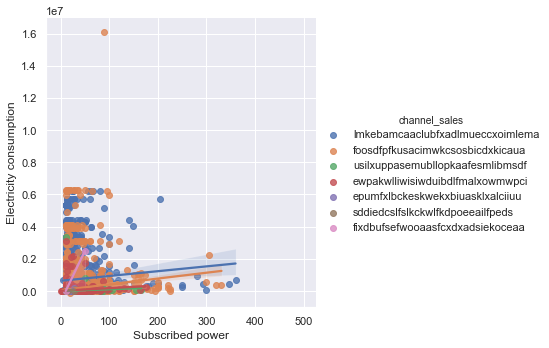

In [11]:
sns.set()
g = sns.lmplot(x = "pow_max", y = "cons_12m", hue = 'channel_sales', scatter = True,
               truncate = True, height = 5, data = data)
plt.savefig('consumption2.png')
plt.show(g.set_axis_labels("Subscribed power", "Electricity consumption"))

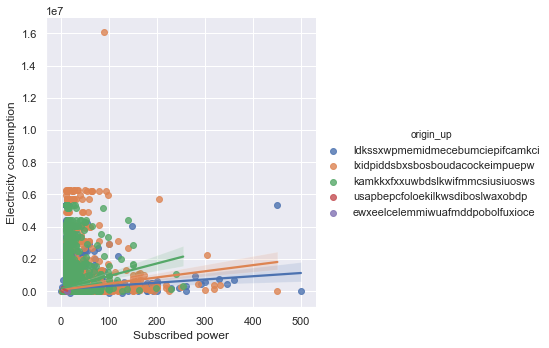

In [12]:
sns.set()
g = sns.lmplot(x = "pow_max", y = "cons_12m", hue = 'origin_up', scatter = True,
               truncate = True, height = 5, data = data)
plt.savefig('consumption3.png')
plt.show(g.set_axis_labels("Subscribed power", "Electricity consumption"))

Visualise the same for different electricity campaigns

# Feature Engineering

/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


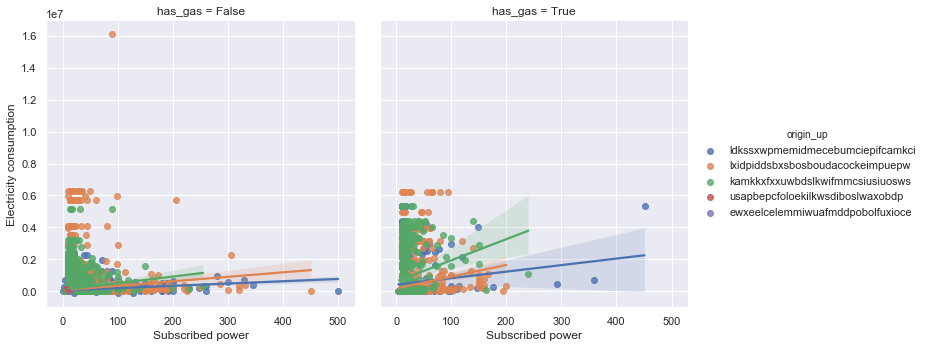

In [13]:
g = sns.lmplot(x = "pow_max", y = "cons_12m", hue = 'origin_up', col = 'has_gas', scatter = True,
               truncate = True, size = 5, data = data)

plt.show(g.set_axis_labels("Subscribed power", "Electricity consumption"))

# Scatter plot with different markers for different electricity campaigns

In [14]:
data.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,...,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,total_cons_12m
count,0.0,1.609600e+04,1.609600e+04,1.609600e+04,3508.000000,3508.000000,3508.000000,3508.000000,16096.000000,16096.000000,...,15970.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,1.609600e+04
mean,NaN,1.948044e+05,3.191164e+04,1.946154e+04,335.843857,335.843857,3837.441866,206.845165,2370.555949,1907.347229,...,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,2.267160e+05
std,NaN,6.795151e+05,1.775885e+05,8.235676e+04,649.406000,649.406000,5425.744327,455.634288,4035.085664,5257.364759,...,5.212252,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,7.791083e+05
min,NaN,-1.252760e+05,-3.037000e+03,-9.138600e+04,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,...,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,-1.252760e+05
25%,NaN,5.906250e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,1158.175000,0.000000,513.230000,0.000000,...,40.606701,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,6.528000e+03
50%,NaN,1.533250e+04,0.000000e+00,9.010000e+02,162.955000,162.955000,2187.230000,42.215000,1179.160000,378.000000,...,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,1.793900e+04
75%,NaN,5.022150e+04,0.000000e+00,4.127000e+03,396.185000,396.185000,4246.555000,228.117500,2692.077500,1994.250000,...,44.311378,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.292275e+04
max,NaN,1.609711e+07,4.188440e+06,4.538720e+06,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,...,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,1.609711e+07


Checking columns with negative values, they need to be fixed somehow in a business process.

In [15]:
data.min()

id                          0002203ffbb812588b632b9e628cc38d
campaign_disc_ele                                        NaN
cons_12m                                             -125276
cons_gas_12m                                           -3037
cons_last_month                                       -91386
date_activ                               2000-07-25 00:00:00
date_end                                 2006-08-26 00:00:00
date_first_activ                         2001-01-10 00:00:00
date_modif_prod                          2000-07-25 00:00:00
date_renewal                             2013-06-26 00:00:00
forecast_base_bill_ele                               -364.94
forecast_base_bill_year                              -364.94
forecast_bill_12m                                   -2503.48
forecast_cons                                              0
forecast_cons_12m                                   -16689.3
forecast_cons_year                                    -85627
forecast_discount_energy

One way to fix negative values in some columns is to assign them to 0. 
I did this, because Module function predicts worse.

In [16]:
data.loc[~(data['cons_12m'] > 0), 'cons_12m'] = 0
data.loc[~(data['cons_gas_12m'] > 0), 'cons_gas_12m'] = 0
data.loc[~(data['cons_last_month'] > 0), 'cons_last_month'] = 0
data.loc[~(data['forecast_cons_12m'] > 0), 'forecast_cons_12m'] = 0
data.loc[~(data['forecast_meter_rent_12m'] > 0), 'forecast_meter_rent_12m'] = 0
data.loc[~(data['forecast_price_pow_p1'] > 0), 'forecast_price_pow_p1'] = 0
data.loc[~(data['imp_cons'] > 0), 'imp_cons'] = 0

data_test.loc[~(data_test['cons_12m'] > 0), 'cons_12m'] = 0
data_test.loc[~(data_test['cons_gas_12m'] > 0), 'cons_gas_12m'] = 0
data_test.loc[~(data_test['cons_last_month'] > 0), 'cons_last_month'] = 0
data_test.loc[~(data_test['forecast_cons_12m'] > 0), 'forecast_cons_12m'] = 0
data_test.loc[~(data_test['forecast_meter_rent_12m'] > 0), 'forecast_meter_rent_12m'] = 0
data_test.loc[~(data_test['forecast_price_pow_p1'] > 0), 'forecast_price_pow_p1'] = 0
data_test.loc[~(data_test['imp_cons'] > 0), 'imp_cons'] = 0

In [17]:
#data['cons_12m'] = data['cons_12m'].abs()
#data['cons_gas_12m'] = data['cons_gas_12m'].abs()
#data['cons_last_month'] = data['cons_last_month'].abs()
#data['forecast_cons_12m'] = data['forecast_cons_12m'].abs()
#data['forecast_meter_rent_12m'] = data['forecast_meter_rent_12m'].abs()
#data['forecast_price_pow_p1'] = data['forecast_price_pow_p1'].abs()
#data['imp_cons'] = data['imp_cons'].abs()

### Remove High Correlated Variables
Helps to fight multicollinearity, which makes the predictions unstable.

The variables whose the correlations  > 0.9: ['cons_last_month', 'forecast_base_bill_year', 'forecast_cons', 'forecast_cons_12m', 'forecast_cons_year', 'imp_cons', 'total_cons_12m']


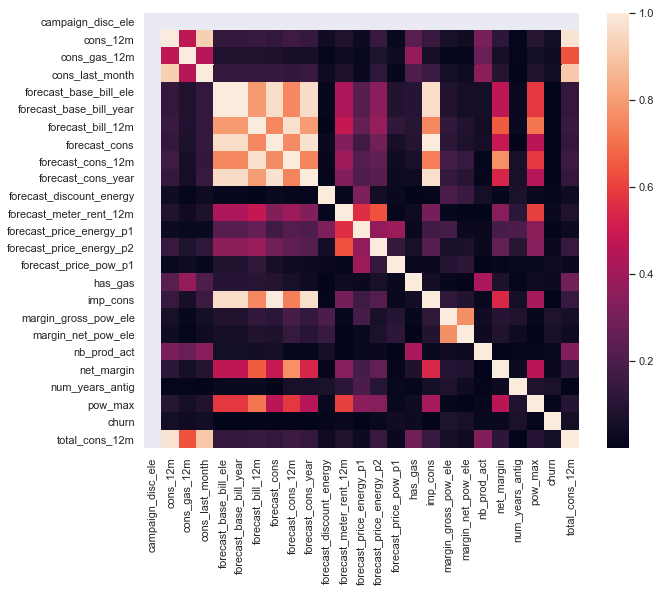

In [18]:
# Calculate the correlation matrix
corr_matrix = data.corr(method = 'pearson').abs()
f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(corr_matrix, mask = np.zeros_like(corr_matrix, dtype = np.bool),
            square = True, ax = ax)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('The variables whose the correlations  > 0.9: {}'.format(to_drop) )

* **forecast_base_bill_year**, **forecast_bill_ele**, **forecast_cons**, **forecast_cons_year** are high correlated with **imp_cons**. Since, **imp_cons** has less missing values, so that we keep only **imp_cons**.
* **forecast_bill_12m** and **forecast_cons_12m** are strongly correlated. Since **forecast_cons_12m** has less missing values, so that we discard **forecast_bill_12m** (78% of missing values).
* **campaign_disc_ele** is an empty column.
* **date_first_activ** has a lot of missing values (78%).

In [19]:
print("% of churned customers is " + str((data["churn"].sum()/len(data))*100.0))

% of churned customers is 9.909294234592446


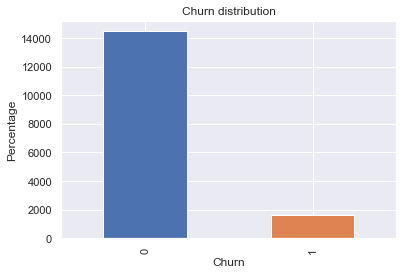

In [20]:
fig, ax = plt.subplots()
ax = data['churn'].value_counts(normalize=False).plot(kind='bar')
ax.set_xlabel('Churn')
ax.set_ylabel('Percentage')
plt.title('Churn distribution')
plt.savefig('churn.png')
plt.show()

# Adding prices

### Pricing Data: 2015

In [21]:
#data_hist = pd.read_csv('ml_case_training_hist_data.csv', index_col='id')
data_hist['price_date'] = pd.to_datetime(data_hist['price_date'])
data_hist.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [22]:
data_hist.isnull().sum()

id                 0
price_date         0
price_p1_var    1359
price_p2_var    1359
price_p3_var    1359
price_p1_fix    1359
price_p2_fix    1359
price_p3_fix    1359
dtype: int64

In [23]:
#data_hist.dropna(inplace = True)
data_hist = data_hist.dropna(how = 'all') #to drop if all values in the row are nan

data_hist.isnull().sum()

id                 0
price_date         0
price_p1_var    1359
price_p2_var    1359
price_p3_var    1359
price_p1_fix    1359
price_p2_fix    1359
price_p3_fix    1359
dtype: int64

In [24]:
print("% of customers without energy pricing for p1: " + str((data_hist.groupby('id')['price_p1_var'].mean() == 0).sum()/data_hist.index.nunique()*100.0))
print("% customers without energy pricing for p2: " + str((data_hist.groupby('id')['price_p2_var'].mean() == 0).sum()/data_hist.index.nunique()*100.0))
print("% customers without energy pricing for p3: " + str((data_hist.groupby('id')['price_p3_var'].mean() == 0).sum()/data_hist.index.nunique()*100.0))
print("% of customers without power pricing for p1: " + str((data_hist.groupby('id')['price_p1_fix'].mean() == 0).sum()/data_hist.index.nunique()*100.0))
print("% customers without power pricing for p2: " + str((data_hist.groupby('id')['price_p2_fix'].mean() == 0).sum()/data_hist.index.nunique()*100.0))
print("% customers without power pricing for p3: " + str((data_hist.groupby('id')['price_p3_fix'].mean() == 0).sum()/data_hist.index.nunique()*100.0))

% of customers without energy pricing for p1: 0.011398845607817535
% customers without energy pricing for p2: 3.7564377571216876
% customers without energy pricing for p3: 4.826374856219107
% of customers without power pricing for p1: 0.061657392151376667
% customers without power pricing for p2: 4.833110537714635
% customers without power pricing for p3: 4.833110537714635


In [25]:
data_hist.min()

id              0002203ffbb812588b632b9e628cc38d
price_date                   2015-01-01 00:00:00
price_p1_var                                   0
price_p2_var                                   0
price_p3_var                                   0
price_p1_fix                           -0.177779
price_p2_fix                           -0.097752
price_p3_fix                           -0.065172
dtype: object

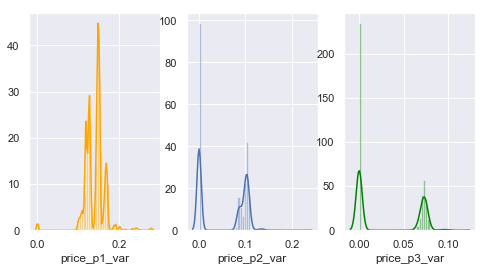

In [26]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(8,4))
ax1 = sns.distplot(data_hist["price_p1_var"].dropna(), ax=ax1, color='orange')
# where available
ax2 = sns.distplot(data_hist["price_p2_var"].dropna(), ax=ax2)
# where available
ax3 = sns.distplot(data_hist["price_p3_var"].dropna(), ax=ax3, color='green')
plt.show()

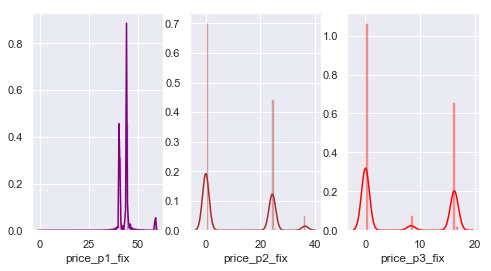

In [27]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(8,4))
ax1 = sns.distplot(data_hist["price_p1_fix"].dropna(), ax=ax1, color='purple')
# where available
ax2 = sns.distplot(data_hist["price_p2_fix"].dropna(), ax=ax2, color='brown')
# where available
ax3 = sns.distplot(data_hist["price_p3_fix"].dropna(), ax=ax3, color='red')
plt.show()

In [28]:
#Creat new vars to describe variation of forecast prices compared with prices in 2015.

#price_mean_2015 = data_hist.groupby('id')['price_p1_var'].mean()
#price_mean_2015 = price_mean_2015.loc[data["id"], ].values
#price_forecast = data['forecast_price_energy_p1']
#data['forecast_price_energy_p1_delta'] = [(p1-p2)/p2*100 if p2!= 0 else 0 for (p1, p2) in zip(price_forecast, price_mean_2015) ]
#data_test['forecast_price_energy_p1_delta'] = [(p1-p2)/p2*100 if p2!= 0 else 0 for (p1, p2) in zip(price_forecast, price_mean_2015) ]
#data['forecast_price_energy_p1_delta'].fillna(0, inplace = True)
#data_test['forecast_price_energy_p1_delta'].fillna(0, inplace = True)

#price_mean_2015 = data_hist.groupby('id')['price_p2_var'].mean()
#price_mean_2015 = price_mean_2015.loc[data["id"], ].values
#price_forecast = data['forecast_price_energy_p2']
#data['forecast_price_energy_p2_delta'] = [(p1-p2)/p2*100 if p2!= 0 else 0 for (p1, p2) in zip(price_forecast, price_mean_2015) ]
#data_test['forecast_price_energy_p2_delta'] = [(p1-p2)/p2*100 if p2!= 0 else 0 for (p1, p2) in zip(price_forecast, price_mean_2015) ]
#data['forecast_price_energy_p2_delta'].fillna(0, inplace = True)
#data_test['forecast_price_energy_p2_delta'].fillna(0, inplace = True)

#price_mean_2015 = data_hist.groupby('id')['price_p1_fix'].mean()
#price_mean_2015 = price_mean_2015.loc[data["id"], ].values
#price_forecast = data['forecast_price_pow_p1']
#data['forecast_price_pow_p1_delta'] = [(p1-p2)/p2*100 if p2!= 0 else 0 for (p1, p2) in zip(price_forecast, price_mean_2015) ]
#data_test['forecast_price_pow_p1_delta'] = [(p1-p2)/p2*100 if p2!= 0 else 0 for (p1, p2) in zip(price_forecast, price_mean_2015) ]
#data['forecast_price_pow_p1_delta'].fillna(0, inplace = True)
#data_test['forecast_price_pow_p1_delta'].fillna(0, inplace = True)

#Creat new variables to describe dynamic of 2015 prices.

#def mean_derivate(prices):
#    return(np.gradient(prices).mean())

#price_p1_var_derivate = data_hist.groupby('id')['price_p1_var'].apply(mean_derivate)
#price_p1_var_derivate = price_p1_var_derivate.loc[data["id"], ].values
#data['price2015_energy_p1_derivate'] = price_p1_var_derivate
#data_test['price2015_energy_p1_derivate'] = price_p1_var_derivate
#data['price2015_energy_p1_derivate'].fillna(0, inplace = True)
#data_test['price2015_energy_p1_derivate'].fillna(0, inplace = True)

#price_p2_var_derivate = data_hist.groupby('id')['price_p2_var'].apply(mean_derivate)
#price_p2_var_derivate = price_p2_var_derivate.loc[data["id"], ].values
#data['price2015_energy_p2_derivate'] = price_p2_var_derivate
#data_test['price2015_energy_p2_derivate'] = price_p2_var_derivate
#data['price2015_energy_p2_derivate'].fillna(0, inplace = True)
#data_test['price2015_energy_p2_derivate'].fillna(0, inplace = True)

#price_p1_fix_derivate = data_hist.groupby('id')['price_p1_fix'].apply(mean_derivate)
#price_p1_fix_derivate = price_p1_fix_derivate.loc[data["id"], ].values
#data['price2015_pow_p1_derivate'] = price_p1_fix_derivate
#data_test['price2015_pow_p1_derivate'] = price_p1_fix_derivate
#data['price2015_pow_p1_derivate'].fillna(0, inplace = True)
#data_test['price2015_pow_p1_derivate'].fillna(0, inplace = True)

In [29]:
data.drop(['campaign_disc_ele', 'date_first_activ', 'forecast_base_bill_year','forecast_base_bill_ele', 'forecast_cons', 'forecast_cons_year', "forecast_bill_12m"], inplace = True, axis = 1)
data_test.drop(['campaign_disc_ele', 'date_first_activ', 'forecast_base_bill_year','forecast_base_bill_ele', 'forecast_cons', 'forecast_cons_year', "forecast_bill_12m"], inplace = True, axis = 1)


There are several options for working with **activity_new** column. Creating dummy variables would create more than 400 columns and make our data sparse. I decided to use the probabilities to stay for each label instead and filling the missing data values with the separate label.

In [30]:
data['activity_new'].fillna('unknown', inplace=True)
data_test['activity_new'].fillna('unknown', inplace=True)


dictd = pd.DataFrame(data['activity_new'].value_counts())
dictd['id'] = dictd.index
dictd.reset_index(drop = True, inplace = True)
dictd.columns = ['count', 'activity_new']


churn_counts = data[data['churn'] == 1]
dictd2 = pd.DataFrame(churn_counts['activity_new'].value_counts())
dictd2['id'] = dictd2.index
dictd2.reset_index(drop = True, inplace = True)
dictd2.columns = ['count_1', 'activity_new']


datafr = pd.merge(dictd, dictd2, how = 'outer', on = 'activity_new')
datafr['probability'] = datafr["count_1"] / datafr['count']
datafr.drop(['count_1', 'count'], inplace = True, axis = 1)


datafr['probability'].fillna(0.0 , inplace=True)
data = pd.merge(data, datafr, on = 'activity_new')
data_test = pd.merge(data_test, datafr, how = 'left', on = 'activity_new')
data_test['probability'].fillna(data_test['probability'].mean(), inplace=True)

data.drop(['activity_new'], inplace = True, axis = 1)
data_test.drop(['activity_new'], inplace = True, axis = 1)

#del churn_counts, datafr, dictd2, dictd

For add values to the missing cells in **activity_new** column, I decided first to see the proportion of existing sales channels. If there is one sales channel that dominates (about 90%) then we can fill in the missing values with that channel, otherwise - fill it with an "unknown" label.

In [31]:
values = data['channel_sales'].value_counts()
count = data['channel_sales'].count()

print("Proportion of sales channels in a dataset:")
print(values/count)

Proportion of sales channels in a dataset:
foosdfpfkusacimwkcsosbicdxkicaua    0.621064
lmkebamcaaclubfxadlmueccxoimlema    0.174524
usilxuppasemubllopkaafesmlibmsdf    0.121569
ewpakwlliwisiwduibdlfmalxowmwpci    0.081327
sddiedcslfslkckwlfkdpoeeailfpeds    0.001010
epumfxlbckeskwekxbiuasklxalciiuu    0.000337
fixdbufsefwooaasfcxdxadsiekoceaa    0.000168
Name: channel_sales, dtype: float64


4 first channels give us 99% of sales.
Although there is one channel that is dominant, there are 3 more that have a considerable proportion in the dataset. I've filled it in with "unknown" label.

In [32]:
data['channel_sales'].fillna('unknown',inplace = True)
data_test['channel_sales'].fillna('unknown',inplace = True)

Transform the modified categorical variable into dummy variables.

In [33]:
dummies = pd.get_dummies(data['channel_sales']).rename(columns = lambda x: 'sale_' + str(x))
data = pd.concat([data, dummies], axis = 1)

dummies = pd.get_dummies(data_test['channel_sales']).rename(columns = lambda x: 'sale_' + str(x))
data_test = pd.concat([data_test, dummies], axis = 1)
data.drop(['channel_sales'], inplace = True, axis = 1)
data_test.drop(['channel_sales'], inplace = True, axis = 1)

In [34]:
# Get the mean duration of each contract
mean_dur = (data["date_end"] - data["date_activ"]).mean()
mean_mod_dur = (data["date_modif_prod"] - data["date_activ"]).mean()
mean_renew_dur = (data["date_renewal"] - data["date_activ"]).mean()

print("Avarage conctract duration is " + str(mean_dur))
print("Avarage conctract lenght till the modification is " + str(mean_mod_dur))
print("Avarage time till the contract renewal is " + str(mean_renew_dur))

Avarage conctract duration is 2018 days 03:45:39.256865
Avarage conctract lenght till the modification is 705 days 15:40:12.874082
Avarage time till the contract renewal is 1645 days 06:07:21.255605


In [35]:
# Get the indices of null values in the date_end column
date_end_ind = data[data["date_end"].isnull()].index.tolist()
date_end_ind_test = data_test[data_test["date_end"].isnull()].index.tolist()

date_mod_ind = data[data["date_modif_prod"].isnull()].index.tolist()
date_mod_ind_test = data_test[data_test["date_modif_prod"].isnull()].index.tolist()

date_renew_ind = data[data["date_renewal"].isnull()].index.tolist()
date_renew_ind_test = data_test[data_test["date_renewal"].isnull()].index.tolist()

In [36]:
# Change series into lists in order to insert values at certain indices
date_activation_list = data["date_activ"].tolist()
date_activation_list_test = data_test["date_activ"].tolist()

date_end_list = data["date_end"].tolist()
date_end_list_test = data_test["date_end"].tolist()

date_mod_list = data["date_modif_prod"].tolist()
date_mod_list_test = data_test["date_modif_prod"].tolist()

date_renew_list = data["date_renewal"].tolist()
date_renew_list_test = data_test["date_renewal"].tolist()

In [37]:
# Change list to have median duration at the NaN indices
for index in date_end_ind:
    date_end_list[index] = date_activation_list[index] + mean_dur
    
for index in date_end_ind_test:
    date_end_list_test[index] = date_activation_list_test[index] + mean_dur

for index in date_mod_ind:
    date_mod_list[index] = date_activation_list[index] + mean_mod_dur
    
for index in date_mod_ind_test:
    date_mod_list_test[index] = date_activation_list_test[index] + mean_mod_dur
    
for index in date_renew_ind:
    date_renew_list[index] = date_activation_list[index] + mean_renew_dur
    
for index in date_renew_ind_test:
    date_renew_list_test[index] = date_activation_list_test[index] + mean_renew_dur

for i in range(len(date_end_list)):
    date_activation_list[i] = date_activation_list[i].value
    date_end_list[i] = date_end_list[i].value
    date_mod_list[i] = date_mod_list[i].value
    date_renew_list[i] = date_renew_list[i].value
    
for i in range(len(date_end_list_test)):
    date_activation_list_test[i] = date_activation_list_test[i].value
    date_end_list_test[i] = date_end_list_test[i].value
    date_mod_list_test[i] = date_mod_list_test[i].value
    date_renew_list_test[i] = date_renew_list_test[i].value

In [38]:
# Convert list back into pandas series
data["date_activ"] = pd.to_datetime(date_activation_list)
data_test["date_activ"] = pd.to_datetime(date_activation_list_test)

data["date_end"] = pd.to_datetime(date_end_list)
data_test["date_end"] = pd.to_datetime(date_end_list_test)

data["date_modif_prod"] = pd.to_datetime(date_mod_list)
data_test["date_modif_prod"] = pd.to_datetime(date_mod_list_test)

data["date_renewal"] = pd.to_datetime(date_renew_list)
data_test["date_renewal"] = pd.to_datetime(date_renew_list_test)

It's important to not introduce any features that we would not have known by the end of Jan 2016

>1. Length of the contract in days
2. How many days since the end of contract was their last renewal?
3. How many days since their last product modification?

In [39]:
# Length of the contract in days
data['contract_long'] = (data["date_end"] - data["date_activ"]).dt.days
data_test['contract_long'] = (data_test["date_end"] - data_test["date_activ"]).dt.days
#data["contract_long"] = data["contract_long"].dt.days

In [40]:
# How many days since the end of the contract was the last renewal?
data['renewal_to_end'] = (data["date_end"] - data["date_renewal"]).dt.days
data_test['renewal_to_end'] = (data_test["date_end"] - data_test["date_renewal"]).dt.days
#data["renewal_to_end"] = data["renewal_to_end"].dt.days

In [41]:
# How many days since the last product modification?
data['modification_deferral'] = (data["date_end"]  - data["date_modif_prod"]).dt.days
data_test['modification_deferral'] = (data_test["date_end"]  - data_test["date_modif_prod"]).dt.days
#data["modification_deferral"] = data["modification_deferral"].dt.days

For **forecast energy** columns, which are continuous variables, it is possible to use the means of these columns to fill in the missing values.

In [42]:
data['forecast_discount_energy'].fillna(data['forecast_discount_energy'].mean(), inplace=True)
data_test['forecast_discount_energy'].fillna(data_test['forecast_discount_energy'].mean(), inplace=True)

data['forecast_price_energy_p1'].fillna(data['forecast_price_energy_p1'].mean(), inplace=True)
data_test['forecast_price_energy_p1'].fillna(data_test['forecast_price_energy_p1'].mean(), inplace=True)

data['forecast_price_energy_p2'].fillna(data['forecast_price_energy_p2'].mean(), inplace=True)
data_test['forecast_price_energy_p2'].fillna(data_test['forecast_price_energy_p2'].mean(), inplace=True)

data['forecast_price_pow_p1'].fillna(data['forecast_price_pow_p1'].mean(), inplace=True)
data_test['forecast_price_pow_p1'].fillna(data_test['forecast_price_pow_p1'].mean(), inplace=True)

Do the same for **margin** columns.

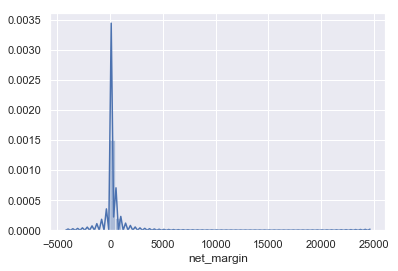

In [43]:
data1 = data[~np.isnan(data["net_margin"])] # Remove the NaNs
ax = sns.distplot(data1["net_margin"].astype(int))

In [44]:
data["margin_gross_pow_ele"].fillna(data["margin_gross_pow_ele"].mean(), inplace = True)
data_test["margin_gross_pow_ele"].fillna(data_test["margin_gross_pow_ele"].mean(), inplace = True)

data["margin_net_pow_ele"].fillna(data["margin_net_pow_ele"].mean(), inplace = True)
data_test["margin_net_pow_ele"].fillna(data_test["margin_net_pow_ele"].mean(), inplace = True)

data["net_margin"].fillna(data["net_margin"].mean(), inplace = True)
data_test["net_margin"].fillna(data_test["net_margin"].mean(), inplace = True)

In [45]:
# Transforming the categorical variable orgin_up.
unique = data["origin_up"].unique()
print("Number of unique values: " + str(len(unique) - 1))
print(data["origin_up"].value_counts())

Number of unique values: 5
lxidpiddsbxsbosboudacockeimpuepw    7825
kamkkxfxxuwbdslkwifmmcsiusiuosws    4517
ldkssxwpmemidmecebumciepifcamkci    3664
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64


As we can see there are 5 different campaigns that customers subscribe to, with 3 campaigns accounting for more than 99% of the campaigns. However, similar to the trouble behind filling missing values in the channel_sales column, we will fill in missing values in origin_up with "unknown".

In [46]:
data['origin_up'].fillna('unknown', inplace=True)
data_test['origin_up'].fillna('unknown', inplace=True)

Transform the modified categorical variable into dummy variables.

In [47]:
dummies = pd.get_dummies(data['origin_up']).rename(columns = lambda x: 'origin_' + str(x))
data = pd.concat([data, dummies], axis = 1)

dummies = pd.get_dummies(data_test['origin_up']).rename(columns = lambda x: 'origin_' + str(x))
data_test = pd.concat([data_test, dummies], axis = 1)

data.drop(['origin_up'], inplace = True, axis = 1)
data_test.drop(['origin_up'], inplace = True, axis = 1)

Lastly, we will add values to the missing values of pow_max
Here, we will look at the median value and add the median to the missing values. 
This is because the mean is likely to get swayed by certain big medium sized 
enterprises who might subscribe to very high power levels.

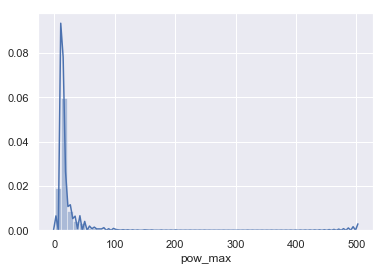

In [48]:
data1 = data[~np.isnan(data["pow_max"])] # Remove the NaNs
ax = sns.distplot(data1["pow_max"].astype(int))

In [49]:
data["pow_max"].fillna(data["pow_max"].median(), inplace = True)
data_test["pow_max"].fillna(data_test["pow_max"].median(), inplace = True)

data["forecast_discount_energy"].fillna(data["forecast_discount_energy"].median(), inplace=True)
data_test["forecast_discount_energy"].fillna(data_test["forecast_discount_energy"].median(), inplace=True)

data["forecast_price_energy_p1"].fillna(data["forecast_price_energy_p1"].median(), inplace=True)
data_test["forecast_price_energy_p1"].fillna(data_test["forecast_price_energy_p1"].median(), inplace=True)

data["forecast_price_energy_p2"].fillna(data["forecast_price_energy_p2"].median(), inplace=True)
data_test["forecast_price_energy_p2"].fillna(data_test["forecast_price_energy_p2"].median(), inplace=True)

In [50]:
#Checking if margin_gross_pow_ele and margin_net_pow_ele are equal completelly.
print(str(data['margin_gross_pow_ele'].equals(data['margin_net_pow_ele'])))

False


In [51]:
# Cleaning of an empty columns and columns with a lot of missing data
list_del = []

for i in data.columns:
    if data[i].isnull().sum() == data.shape[0]: # or len(data[i].unique()) < 3
        list_del.append(i)
data.drop(list_del, axis = 1, inplace = True)
print('The following columns were deleted:', list_del)

The following columns were deleted: []


In [52]:
data = data.dropna(how = 'all') #to drop if all values in the row are nan
data_test = data_test.dropna(how = 'all') #to drop if all values in the row are nan

print(data.shape) #we still have the churn column
print(data_test.shape)

(16096, 42)
(4024, 40)


# Building a model and tuning parameters

Start building ML models. I will use Decision Tree, Bagging Classifier,
Logistic Regression, Random Forest, Adaptive Boosting, and finally a 
Voting Classifier that incorporates the best of these models.

In [53]:
y = data['churn']
data.drop(['churn'], axis=1, inplace=True)

In [54]:
data.drop(['id', 'date_activ', 'date_end', 'date_modif_prod', "date_renewal"], inplace = True, axis = 1)
data_test.drop(['id', 'date_activ', 'date_end', 'date_modif_prod', "date_renewal"], inplace = True, axis = 1)

data.dtypes

cons_12m                                     int64
cons_gas_12m                                 int64
cons_last_month                              int64
forecast_cons_12m                          float64
forecast_discount_energy                   float64
forecast_meter_rent_12m                    float64
forecast_price_energy_p1                   float64
forecast_price_energy_p2                   float64
forecast_price_pow_p1                      float64
has_gas                                       bool
imp_cons                                   float64
margin_gross_pow_ele                       float64
margin_net_pow_ele                         float64
nb_prod_act                                  int64
net_margin                                 float64
num_years_antig                              int64
pow_max                                    float64
total_cons_12m                               int64
probability                                float64
sale_epumfxlbckeskwekxbiuasklxa

# Scaling Variables
---
Normalise trainind datasets into a scale between 0 and 1 before using them together.

In [55]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [56]:
data = normalize(data[['cons_12m', 'cons_gas_12m', 'cons_last_month','forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_p1', 'forecast_price_energy_p2', 'forecast_price_pow_p1', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max', 'total_cons_12m', 'contract_long', 'renewal_to_end', 'modification_deferral']])
data_test = normalize(data_test[['cons_12m', 'cons_gas_12m', 'cons_last_month','forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_p1', 'forecast_price_energy_p2', 'forecast_price_pow_p1', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max', 'total_cons_12m', 'contract_long', 'renewal_to_end', 'modification_deferral']])

In [57]:
# Spliting our data
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.33, random_state = 33, stratify = y)

In [58]:
# Tried to use techniques (SMOTE) to fight the class imbalance, but they did not help.
#X_train_res, X_test, y_train_res, y_test = train_test_split(data, y, test_size = 0.33, random_state = 33, stratify = y)

In [59]:
#from imblearn.over_sampling import SMOTE
#print("Before OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))

#sm = SMOTE(random_state = 2)
#X_train, y_train = sm.fit_sample(X_train_res, y_train_res.ravel())

#print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

In [60]:
# Strandartisation
#data["cons_12m"] = (data["cons_12m"] - data["cons_12m"].mean()) / data["cons_12m"].std()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
# Did not help much as well
#from sklearn.decomposition import PCA
# Make an instance of the Model
#pca = PCA(.95)
#pca.fit(X_train)

#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

### DecisionTreeClassifier

In [62]:
#StratifiedKFold(n_splits=10)
tc = DecisionTreeClassifier()
params = {'max_depth':[2,4,8]}

tcgrid = RandomizedSearchCV(estimator = tc, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
tcgrid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'max_depth': [2, 4, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [63]:
tc_predictions = tcgrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, tc_predictions)* 100.0))

Accuracy is 90.10%


In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, tc_predictions)
print(confusion_matrix)

[[4786    0]
 [ 526    0]]


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tc_predictions))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      4786
          1       0.00      0.00      0.00       526

avg / total       0.81      0.90      0.85      5312



/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


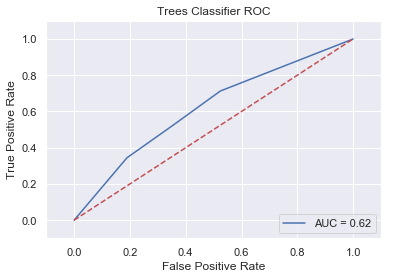

In [66]:
tc_predictions_proba = tcgrid.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, tc_predictions_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Trees Classifier ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
print("Brier: %1.3f" % (brier_score_loss(y_test, tc_predictions_proba, pos_label=y.max())))

Brier: 0.088


### Logistic regression

In [68]:
log = LogisticRegression()
params = {'C':[0.01, 0.1, 1, 10]}

loggrid = RandomizedSearchCV(estimator = log, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
loggrid.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'C': [0.01, 0.1, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [69]:
lr_predictions = loggrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, lr_predictions)* 100.0))

Accuracy is 90.10%


In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, lr_predictions)
print(confusion_matrix)

[[4784    2]
 [ 524    2]]


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_predictions))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      4786
          1       0.50      0.00      0.01       526

avg / total       0.86      0.90      0.85      5312



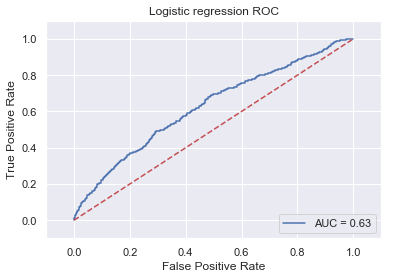

In [72]:
lr_predictions_proba = loggrid.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lr_predictions_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Logistic regression ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
print("Brier: %1.3f" % (brier_score_loss(y_test, lr_predictions_proba, pos_label=y.max())))

Brier: 0.087


### Random forest classifier

In [74]:
rf = RandomForestClassifier()
params = {'max_depth': [8, 16, 32], 'min_samples_leaf':[2, 4, 8]}

rfgrid = RandomizedSearchCV(estimator = rf, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
rfgrid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'max_depth': [8, 16, 32], 'min_samples_leaf': [2, 4, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [75]:
rf_predictions = rfgrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, rf_predictions)* 100.0))

Accuracy is 90.15%


In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, rf_predictions)
print(confusion_matrix)

[[4783    3]
 [ 520    6]]


In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predictions))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      4786
          1       0.67      0.01      0.02       526

avg / total       0.88      0.90      0.86      5312



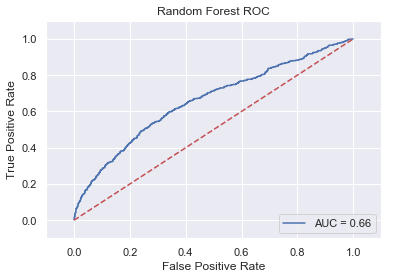

In [78]:
rf_predictions_proba = rfgrid.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_predictions_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Random Forest ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [79]:
print("Brier: %1.3f" % (brier_score_loss(y_test, rf_predictions_proba, pos_label=y.max())))

Brier: 0.086


In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel

name_features = data.columns

#Select Important Features In Random Forest
score_rf = rfgrid.best_estimator_.feature_importances_

Index(['margin_net_pow_ele', 'margin_gross_pow_ele', 'forecast_meter_rent_12m',
       'net_margin', 'forecast_cons_12m', 'cons_12m', 'total_cons_12m',
       'forecast_price_energy_p1', 'modification_deferral', 'pow_max',
       'cons_last_month', 'contract_long', 'imp_cons',
       'forecast_price_energy_p2', 'renewal_to_end', 'forecast_price_pow_p1',
       'cons_gas_12m', 'forecast_discount_energy'],
      dtype='object')
[0.07012723 0.00692076 0.05689258 0.07530177 0.00571784 0.08394967
 0.06259663 0.03525005 0.02334695 0.04761241 0.08671463 0.09916975
 0.080963   0.05835502 0.06639871 0.05215577 0.02716247 0.06136477]


Text(0,0.5,'Score')

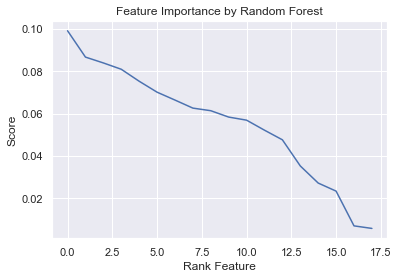

In [81]:
feature_rf = name_features[( -score_rf).argsort()][:30]
print(feature_rf)
print(score_rf)
plt.plot( np.arange(18), -np.sort( -score_rf))
plt.title('Feature Importance by Random Forest')
plt.xlabel('Rank Feature')
plt.ylabel('Score')

### XGBClassifier

In [82]:
#from scipy import stats
#xgb = XGBClassifier()
#xgb_params = xgb.get_xgb_params()
#xgb = XGBClassifier(**xgb_params)

#xgb.fit(X_train, y_train)
#params = {'n_estimators': stats.randint(150, 1000),
#              'learning_rate': stats.uniform(0.01, 0.6),
#              'subsample': stats.uniform(0.3, 0.9),
#              'max_depth': [3, 4, 5, 6, 7, 8, 9],
#              'colsample_bytree': stats.uniform(0.5, 0.9),
#              'min_child_weight': [1, 2, 3, 4]}

#xgbgrid = RandomizedSearchCV(xgb, param_distributions = params,
#                             cv = StratifiedKFold(n_splits=10),  n_iter = 3, scoring = 'accuracy', 
#                             error_score = 0, verbose = 3, n_jobs = -1) #roc_auc)
#xgbgrid.fit(X_train, y_train)

In [83]:
#xgb_predictions = xgbgrid.predict(X_test)
#print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, xgb_predictions)* 100.0))

In [84]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix = confusion_matrix(y_test, xgb_predictions)
#print(confusion_matrix)

In [85]:
#from sklearn.metrics import classification_report
#print(classification_report(y_test, xgb_predictions))

In [86]:
#xgb_predictions_proba = xgbgrid.predict_proba(X_test)[:,1]

#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, xgb_predictions_proba)
#roc_auc = auc(false_positive_rate, true_positive_rate)

#plt.title('XGboost ROC')
#plt.plot(false_positive_rate, true_positive_rate, 'b',
#label = 'AUC = %0.2f'% roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0,1], [0,1], 'r--')
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
#plt.grid(True)
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()

### Naive Bayes

In [87]:
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None)

In [88]:
nb_predictions = nb.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, nb_predictions)* 100.0))

Accuracy is 24.62%


In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, nb_predictions)
print(confusion_matrix)

[[ 849 3937]
 [  67  459]]


In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_predictions))

             precision    recall  f1-score   support

          0       0.93      0.18      0.30      4786
          1       0.10      0.87      0.19       526

avg / total       0.85      0.25      0.29      5312



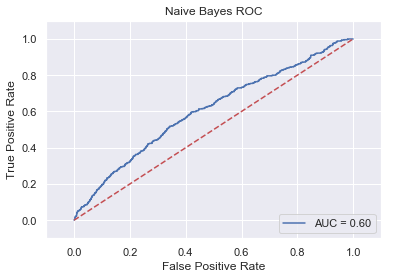

In [91]:
nb_predictions_proba = nb.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, nb_predictions_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Naive Bayes ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
print("Brier: %1.3f" % (brier_score_loss(y_test, nb_predictions_proba, pos_label=y.max())))

Brier: 0.511


## SVM classifier

In [93]:
#from sklearn.svm import SVC
#svc = SVC(C = 1, kernel = 'rbf', probability = True,  random_state = 0, class_weight = 'balanced')

#svc.fit(X_train, y_train)

In [94]:
#svc_predictions = svc.predict(X_test)
#print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, svc_predictions)* 100.0))

In [95]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix = confusion_matrix(y_test, svc_predictions)
#print(confusion_matrix)

In [96]:
#from sklearn.metrics import classification_report
#print(classification_report(y_test, svc_predictions))

In [97]:
#svc_predictions_proba = svc.predict_proba(X_test)[:,1]

#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, svc_predictions_proba)
#roc_auc = auc(false_positive_rate, true_positive_rate)

#plt.title('SVC ROC')
#plt.plot(false_positive_rate, true_positive_rate, 'b',
#label = 'AUC = %0.2f'% roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0,1], [0,1], 'r--')
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
#plt.grid(True)
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()

### Bagging Classifier

In [98]:
bag = BaggingClassifier(base_estimator = tcgrid.best_estimator_, n_estimators = 2)
params = {'base_estimator':[tcgrid.best_estimator_, loggrid.best_estimator_, rfgrid.best_estimator_, nb],'n_estimators':[2, 3, 4]}

baggrid = RandomizedSearchCV(estimator = bag, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
baggrid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise',
          estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min... n_estimators=2, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...None, verbose=0,
            warm_start=False), GaussianNB(priors=None)], 'n_estimators': [2, 3, 4]

In [99]:
bg_predictions = baggrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, bg_predictions)* 100.0))

Accuracy is 90.15%


In [100]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, bg_predictions)
print(confusion_matrix)

[[4786    0]
 [ 523    3]]


In [101]:
from sklearn.metrics import classification_report
print(classification_report(y_test, bg_predictions))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      4786
          1       1.00      0.01      0.01       526

avg / total       0.91      0.90      0.86      5312



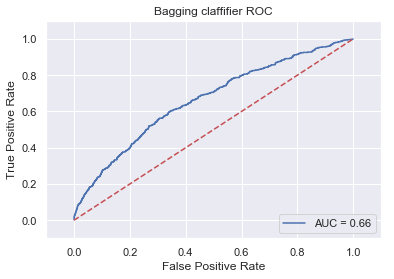

In [102]:
bg_predictions_proba = baggrid.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, bg_predictions_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Bagging claffifier ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
print("Brier: %1.3f" % (brier_score_loss(y_test, bg_predictions_proba, pos_label=y.max())))

Brier: 0.086


### Adaboost Classifier

In [104]:
ada = AdaBoostClassifier(base_estimator = rfgrid.best_estimator_, n_estimators = 4)
params = {'base_estimator':[tcgrid.best_estimator_, loggrid.best_estimator_, rfgrid.best_estimator_, nb],'n_estimators':[2, 3, 4]}

adagrid = RandomizedSearchCV(estimator = ada, param_distributions = params, cv = StratifiedKFold(n_splits = 10, shuffle = True), scoring='accuracy', n_iter = 3)
adagrid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_s...se=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=4, random_state=None),
          fit_params=None, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...None, verbose=0,
            warm_start=False), GaussianNB(priors=None)], 'n_estimators': [2, 3, 4]

In [105]:
ada_predictions = adagrid.predict(X_test)
print("Accuracy is %.2f%%" %(metrics.accuracy_score(y_test, ada_predictions)* 100.0))

Accuracy is 90.38%


In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, ada_predictions)
print(confusion_matrix)

[[4781    5]
 [ 506   20]]


In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ada_predictions))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      4786
          1       0.80      0.04      0.07       526

avg / total       0.89      0.90      0.86      5312



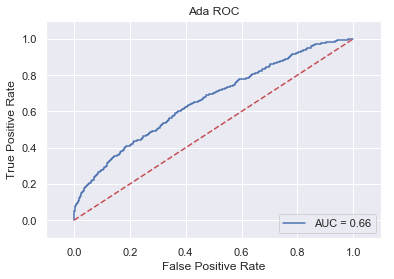

In [108]:
ada_predictions = adagrid.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, ada_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Ada ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ada.png')
plt.show()

In [109]:
print("Brier: %1.3f" % (brier_score_loss(y_test, ada_predictions, pos_label=y.max())))

Brier: 0.107


Index(['margin_net_pow_ele', 'margin_gross_pow_ele', 'forecast_meter_rent_12m',
       'net_margin', 'forecast_cons_12m', 'cons_12m', 'total_cons_12m',
       'forecast_price_energy_p1', 'modification_deferral', 'pow_max',
       'cons_last_month', 'contract_long', 'imp_cons',
       'forecast_price_energy_p2', 'renewal_to_end', 'forecast_price_pow_p1',
       'cons_gas_12m', 'forecast_discount_energy'],
      dtype='object')
[0.07012723 0.00692076 0.05689258 0.07530177 0.00571784 0.08394967
 0.06259663 0.03525005 0.02334695 0.04761241 0.08671463 0.09916975
 0.080963   0.05835502 0.06639871 0.05215577 0.02716247 0.06136477]


Text(0,0.5,'Score')

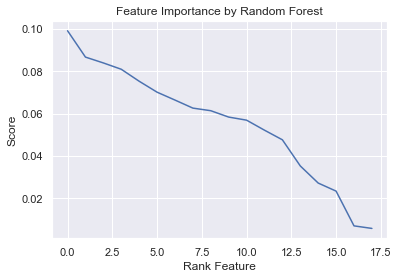

In [110]:
feature_rf = name_features[(-score_rf).argsort()][:30]
print(feature_rf)
print(score_rf)
plt.plot( np.arange(18), -np.sort(-score_rf))
plt.title('Feature Importance by Random Forest')
plt.xlabel('Rank Feature')
plt.ylabel('Score')

## Final prediction

In [111]:
# Predict churned customers based on adaboost

final_pred = adagrid.predict(data_test)

final_pred_prob = adagrid.predict_proba(data_test)
prob = final_pred_prob[:,1]

indices_list = [i for i in range(len(final_pred))]

prediction = pd.DataFrame(
{'index': indices_list,
 'id': data_test_id,
 'Churn_prediction': final_pred,
 'Churn_probability': prob})

# Place in descending order of probability to churn
prediction = prediction[['index', 'id', 'Churn_prediction', 'Churn_probability']]
prediction = prediction.sort_values('Churn_probability', ascending = False)
prediction.to_csv('ml_case_test_output.csv', index = False)

# Analysing discount

In [112]:
# Get the indices of these customers and add them to a list so 
# that we can access it more easily for future steps.

churned_index = prediction["index"].tolist()
print(len(churned_index))

4024


In [113]:
price_data = pd.read_csv('ml_case_test_hist_data.csv')


count1 = []
price_data['price_p1_var'].fillna(0,inplace=True)
for i in price_data['price_p1_var'].iteritems():
    if i[1]!=0:
        count1.append(1)
    else:
        count1.append(0)

count2 = []
price_data['price_p2_var'].fillna(0,inplace=True)
for i in price_data['price_p2_var'].iteritems():
    if i[1]!=0:
        count2.append(1)
    else:
        count2.append(0)

count3 = []
price_data['price_p3_var'].fillna(0,inplace=True)
for i in price_data['price_p3_var'].iteritems():
    if i[1]!=0:
        count3.append(1)
    else:
        count3.append(0)

count = []
for i in range(len(count1)):
    count.append(count1[i]+count2[i]+count3[i])

price_data['count'] = count

# Create new columns for the average variable price and the total fixed price for each price date

price_data['avg_price_var'] = (price_data['price_p1_var'] + price_data['price_p2_var'] + price_data['price_p3_var'])/price_data['count']
price_data['sum_price_fix'] = 30*(price_data['price_p1_fix'] + price_data['price_p2_fix'] + price_data['price_p3_fix'])

price_data = price_data.drop(['count'],axis = 1)

In [114]:
# Group by customer id and get the average 12 month prices for
# the variable price and the total sum 12 month prices for the 
# fixed prices

id_=[]
for i in price_data['id'].iteritems():
    if i[1] in id_:
        pass
    else:
        id_.append(i[1])

avg_var_12m = price_data.groupby('id', sort = False)['avg_price_var'].mean()
#price_p1_fix_derivate = data_hist.groupby('id')['price_p1_fix'].apply(mean_derivate)

sum_fix_12m = price_data.groupby('id', sort = False)['sum_price_fix'].sum()

temp_data = pd.DataFrame(
  {'id':id_,
   'avg_var_12m':avg_var_12m,
   'fix_12m':sum_fix_12m})

temp_data = temp_data[['avg_var_12m','fix_12m']]

In [115]:
data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,net_margin,pow_max,total_cons_12m,contract_long,renewal_to_end,modification_deferral
0,0.019213,0.000000,0.002209,0.255489,0.0,0.148979,0.350117,0.450808,0.992451,0.055296,0.537426,0.579521,0.204785,0.358717,0.026787,0.196942,0.439807,0.512821
1,0.000339,0.008214,0.000172,0.007923,0.0,0.004155,0.535452,0.000000,0.745422,0.007661,0.615810,0.650772,0.147277,0.021042,0.010180,0.328417,0.437400,0.592580
2,0.002764,0.000000,0.000947,0.031620,0.0,0.055102,0.420400,0.504335,0.683100,0.021557,0.617410,0.652227,0.157220,0.064128,0.010465,0.394245,0.439540,0.632515
3,0.000874,0.000000,0.000218,0.014495,0.0,0.053742,0.439373,0.528062,0.683100,0.006630,0.652736,0.684338,0.150254,0.060220,0.008590,0.131295,0.440075,0.367594
4,0.008697,0.000000,0.003157,0.132825,0.0,0.000000,0.409836,0.489568,0.683100,0.091199,0.576174,0.614743,0.179670,0.318637,0.016353,0.262950,0.440342,0.552864


In [116]:
data = pd.concat([data, data_id], axis = 1)
temp_data = temp_data.reset_index()

In [117]:
print(data.shape)
temp_data.head()

(16096, 19)


,id,avg_var_12m,fix_12m
0,3acc714fbd9b3ccaac3c412cf220e929,0.126956,15968.095330
1,cd0e9211c709585dacc63a0bc89e54bf,0.149855,15968.095330
2,0d46a2151788af3f93620d4f598e3f76,0.100758,29266.147440
3,73df0b25958255f478ddfdf5a7a3e1fb,0.111305,29535.068034
4,c8f997f57c51f9429d546cdbe7ce93c2,0.095481,26832.189420


In [118]:
temp_data.head()

,id,avg_var_12m,fix_12m
0,3acc714fbd9b3ccaac3c412cf220e929,0.126956,15968.095330
1,cd0e9211c709585dacc63a0bc89e54bf,0.149855,15968.095330
2,0d46a2151788af3f93620d4f598e3f76,0.100758,29266.147440
3,73df0b25958255f478ddfdf5a7a3e1fb,0.111305,29535.068034
4,c8f997f57c51f9429d546cdbe7ce93c2,0.095481,26832.189420


In [119]:
# Merge the pricing dataframe with the test dataframe to order
# the prices appropriately according to the customer id's
#data = pd.merge(data, output, on = 'id')

data = pd.merge(data, temp_data, how = 'outer', on = 'id')

data['revenue'] = data['avg_var_12m'] * data['cons_12m'] + data['fix_12m']
data['profit'] = data['revenue'] * data['margin_net_pow_ele']

churned_net_mar = data['margin_net_pow_ele'].iloc[churned_index]

# Amount of profit lost from churned customers, divided by 100
# to convert from cents to dollars.

churned_profit = data['profit'].iloc[churned_index]
print("Profit loss from churning customers:")
print('$',churned_profit.sum() / 100)
print("")

# Increase in profit if we offer 20% discount to customers
# predicted to churn, divided by 100 to convert from cents
# to dollars.

disc_churned_profit = churned_profit * 0.8
print("Profit recovered from churning customers with 20% discount:")
print('$',disc_churned_profit.sum() / 100)

Profit loss from churning customers:
$ 0.0

Profit recovered from churning customers with 20% discount:
$ 0.0
